In [10]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from matplotlib import gridspec
import matplotlib
from tqdm import tqdm_notebook
from astropy import units
from matplotlib.colors import LogNorm
from astropy.table import Table
from astropy.io import fits

# nicer looking plots
import matplotlib as mpl
mpl.rcParams['xtick.labelsize']=18
mpl.rcParams['ytick.labelsize']=18


%matplotlib inline

from pylab import *
colormap='viridis'

cmap = cm.get_cmap(colormap, 20)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

#parula_colors = np.load('/Users/arcticfox/parula_colors.npy')

path = '/Users/belugawhale/Documents/mass_loss'
dpath = '/Users/belugawhale/Documents/GitHub/cos_flares/data'

sys.path.append(path)
# planet structure modules
import solve_for_masses as em
import mass_loss as ms
import planet_structure as ps

We weill solve for the evolution of the planet using a simple model based on Owen & Wu (2017), the evolution of the planet will follow the simple ODE:

$$ \frac{d X}{dt}= - \frac{X}{t_{\dot{m}}} $$

where $X=M_{\rm atm}/M_{\rm core}$ is the envelope mass fraction and $t_{\dot{m}}$ is the mass-loss time-scale defined as $M_{\rm atm}/\dot{M}$. For simplicity the mass-loss rate is calculated using the energy-limited model with a constant efficiency ($\eta$), namely:

$$
\dot{M}=\eta \frac{\pi R_p^3 L_{\rm HE}}{4\pi a^2 G M_{\rm core}}
$$
    
    
The conversion between envelope mass fraction and planet radius and atmosphere mass is calculated using the semi-analytic framework of Owen & Campos Estrada (2020)    

In [3]:
def planck(lam, T, rad):
    result = 2.*np.pi*const.h*(const.c**2)/(lam**5)
    result /= (np.exp(const.h*const.c/(lam*const.k_B*T)) - 1.0)
   # result *= (4* np.pi**2 * rad**2)
    result *= (lam[1]-lam[0])
    return result.to(units.erg/units.s/units.m**2)

In [4]:
# this function calculates the mass-loss timescale
def lum_highenergy(time):
    lsun = (1*units.Lsun).to(units.erg/units.s).value
    mratio = (0.3*units.Msun)/(1.0*units.Msun)
    lsat = 10**(-3.5)*lsun*(mratio.value)
    lsat = 3.4e28#*units.erg/units.s # comes from Hubble/COS estimate
    return lsat * (time/100.)**(-1.-0.5)


def get_txdot(Rp,mcore,time,eta, flares, time_cutoff):
    global energies, distribution
    
    x, f, Rp_check = ps.Rp_solver(Rp,
                                  Teq,
                                  mcore,
                                  time,Xiron,Xice)
    
    og_time = time
    
    Menv = x*mcore*5.97e27
    
    if (time < 100.):
        time = 100.
        
    LHE = lum_highenergy(time)

    injected = False
    flare_energy = 0
    
    if flares is True and og_time <= time_cutoff:
        randomizer = np.random.randint(0,3,1)
        if randomizer == 0:
            flare_energy = np.random.choice(energies, 1, 
                                            p=distribution,
                                            replace=True)*units.erg/units.s
            flare_energy = flare_energy[0].value
            LHE = flare_energy + 0.0
            injected = True
    

    Mdot = eta * np.pi * Rp**3. * (LHE/(4.*np.pi*sep**2.)) / (G * mcore*5.97e27) 
    
    return Menv/Mdot, LHE, injected, flare_energy, Mdot

In [5]:
# This returns the RHS of the ODE
def ode_to_solve(x,time,mcore,eta,flares,time_cutoff):
    
    # convert x to radius
    Rrcb,f,Rp,deltaR = ps.solve_structure(x,Teq,mcore,time,Xiron,Xice)
    
    # get tmdot 
    tmdot, LHE, injected, flare_energy, Mdot = get_txdot(Rp,mcore,time,eta,flares,time_cutoff)
    
    return x/tmdot, LHE, injected, flare_energy, Mdot

In [6]:
# This advances the ODE using a very crude first-order explicit integrator by 
# one time-step (that is adaptively calculated so the envelope mass-fraction changes by a small amount)
def simple_integrator_advance(x,time,mcore,eta,flares,time_cutoff):
    
    # simple integrator to advance the envelope mass fraction by a little bit:
    
    dx_dt, LHE, injected, flare_energy, Mdot = ode_to_solve(x,time,mcore,eta,flares,time_cutoff)
    if injected:
        dt = 10**10 #0.003*x/dx_dt/100.
    else:
        dt = 10**13 #0.003*x/dx_dt
    
    x_new = x - dt*dx_dt
    #print(x - dt*dx_dt)
    
    return x_new, dt, LHE, injected, flare_energy, Mdot

In [31]:
# computes the evolution of the planetary variables
def solve_problem(Rpinit,tinit,mcore,eta,flares=False,time_cutoff=100):
    global MAX_AGE
    
    x, f,Rp = ps.Rp_solver(Rpinit,
                           Teq,
                           mcore,
                           tinit,Xiron,Xice)
    
    luminosity = np.array([lum_highenergy(100)])
    time_out = np.array([tinit])
    x_out = np.array([x])
    Rp_out = np.array([Rpinit])
    flare_energies = np.array([0])
    mdots = np.array([0])
    
    while (time_out[-1] < MAX_AGE):
    
        x_new, dt, LHE, injected, flare_energy, Mdot = simple_integrator_advance(x_out[-1],
                                                                                 time_out[-1],
                                                                                 mcore,eta,flares,
                                                                                 time_cutoff)
        flare_energies = np.append(flare_energies, flare_energy)
        mdots= np.append(mdots,Mdot)
        x_out = np.append(x_out,x_new)

        dt = dt/31556926./1e6 # in Myr

        time_out = np.append(time_out,time_out[-1]+dt)
        
        ## this takes time_out[-1] in Myr. in code, need to fix to not do that
        Rrcb,f,Rp_new,deltaR = ps.solve_structure(x_out[-1],Teq,mcore,
                                                  time_out[-1],
                                                  Xiron,Xice)
        
        Rp_out = np.append(Rp_out, Rp_new)

        luminosity = np.append(luminosity, LHE)
        
        if (x_out[-1] < 1e-10):
            print(x_out[-1], time_out[-1], flare_energies[-1])
            break
            
    return time_out, x_out, Rp_out, luminosity, flare_energies, mdots

In [32]:
#brem = Table.read(os.path.join(path,'bremfit.csv'), format='csv')

def get_euv_duvvuri(path, filename='spectrum_au_mic_f_p17.fits'):
    data = fits.open(os.path.join(path, filename))
    
    return (data[1].data['Wavelength'], data[1].data['Flux_density'], 
            data[1].data['Lower_Error_16'], data[1].data['Upper_Error_84'])

qw, qf, ql, qu = get_euv_duvvuri(dpath, filename='spectrum_au_mic_q_p17.fits')
fw, ff, fl, fu = get_euv_duvvuri(dpath)

ff=ff*units.erg/units.s/units.cm**2/units.AA
fw=fw*units.AA

#qf=qf*units.erg/units.s/units.cm**2/units.AA
#qw=qw*units.AA

factor=4*np.pi*(9.72*units.pc)**2

In [33]:
q = qw < 1100
out = np.trapz(qf[q]*units.erg/units.s/units.cm**2/units.AA,
               qw[q]*units.AA)*factor
quiescent = out.to(units.erg/units.s)

In [34]:
q = fw.value < 1100
(np.trapz(ff[q], fw[q])*factor).to(units.erg/units.s)

<Quantity 3.64757821e+29 erg / s>

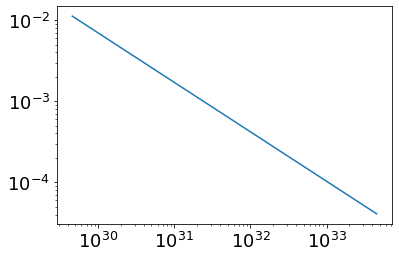

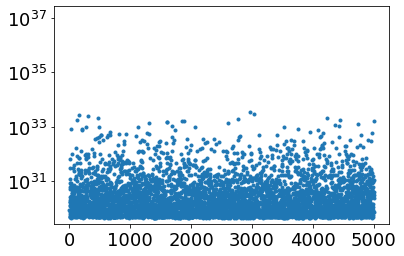

In [35]:
q = fw.value<1100
LHE = quiescent + 0.0
#LHE_flare = (np.trapz(ff*units.erg/units.s/units.cm**2/units.AA,
#              fw*units.AA)*factor).to(units.erg/units.s)         # with bremsstrahlung
LHE_flare = (np.trapz(ff,fw)*factor).to(units.erg/units.s)

energies = np.logspace(np.log10(LHE_flare.value), np.log10(LHE_flare.value*10000), 500)
alpha = -0.61
distribution = energies**alpha
distribution /= np.nansum(distribution)

plt.plot(energies, distribution)
plt.xscale('log')
plt.yscale('log')
plt.show()

samples = np.random.choice(energies, 5000, 
                           p=distribution/np.nansum(distribution), 
                           replace=True)#*units.erg/units.s
plt.plot(samples,'.')
plt.yscale('log')
plt.ylim(LHE.value, LHE.value*1e8);

In [38]:
Rp_aumicb = (4.07 * units.Rearth).to(units.cm).value# 6.371e8
Age_aumicb = 23. 
mcore = (5.*units.Mearth).to(units.g).value

Teq = 593. # equil temperature
Xiron = 1./3. # Iron mass fraction in core
Xice = 0. # Ice mass fraction in core
sep = (0.0645*units.AU).to(units.cm).value#*1.5e13 # orbital separation
G = (const.G).to(units.cm**3/units.s**2/units.g).value#6.67e-8 # G in cgs

MAX_AGE = 1000. 

# low-mass loss efficiency
np.random.seed(456)
eta = 0.15

outputs = []

for mcore in [5,8,10]:
    print('----- MCORE = {} -----'.format(mcore))

    t1,x1,Rp1,lhe1,a1,m1 = solve_problem(Rp_aumicb, Age_aumicb, 
                                         mcore, eta, flares=False,
                                         time_cutoff=MAX_AGE)
    outputs.append([t1,x1,Rp1,lhe1,a1,m1])

    for cutoff in [200,MAX_AGE]:
        print('----- CUTOFF = {} -----'.format(cutoff))
        t2,x2,Rp2,lhe2,a2,m2 = solve_problem(Rp_aumicb, Age_aumicb, 
                                             mcore, eta, flares=True,
                                             time_cutoff=cutoff)
        outputs.append([t2,x2,Rp2,lhe2,a2,m2])

----- MCORE = 5 -----
----- CUTOFF = 200 -----
----- CUTOFF = 1000.0 -----
----- MCORE = 8 -----
----- CUTOFF = 200 -----
----- CUTOFF = 1000.0 -----
----- MCORE = 10 -----
----- CUTOFF = 200 -----
----- CUTOFF = 1000.0 -----


In [39]:
for i in range(3):
    print(np.log10(outputs[i][-2][[np.argmax(outputs[i][-2])]]))
    print(outputs[i][-1][np.argmax(outputs[i][-2])]*units.g/units.s/1e10)

[-inf]
0.0 g / s
[33.07316974]
30817.088492791074 g / s
[33.61825993]
35962.335074993614 g / s


/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_7909/2979977845.py:2: RuntimeWarning: divide by zero encountered in log10
  print(np.log10(outputs[i][-2][[np.argmax(outputs[i][-2])]]))


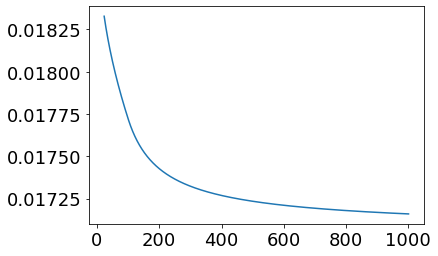

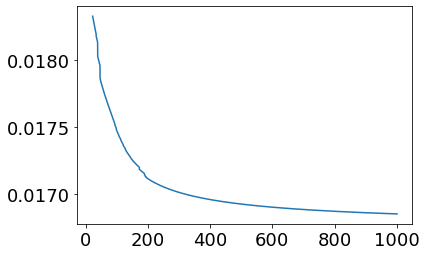

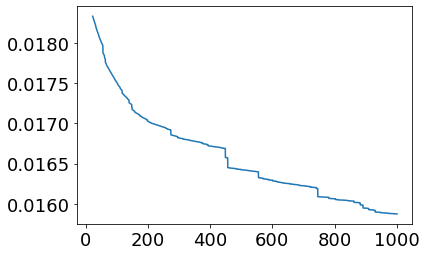

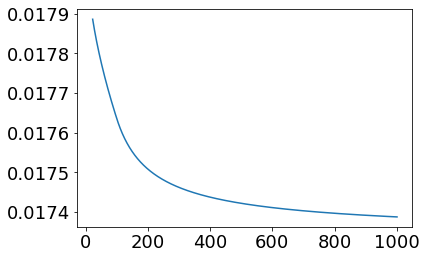

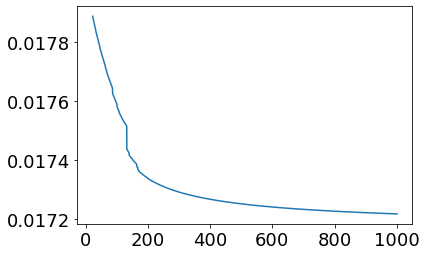

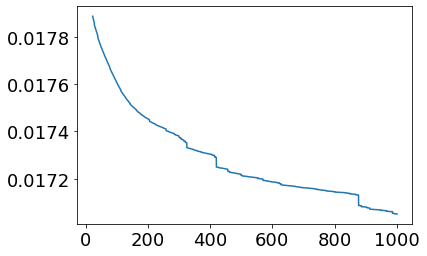

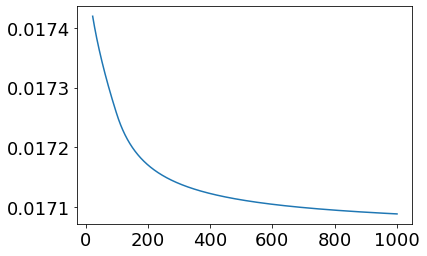

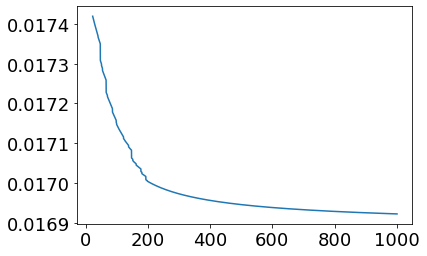

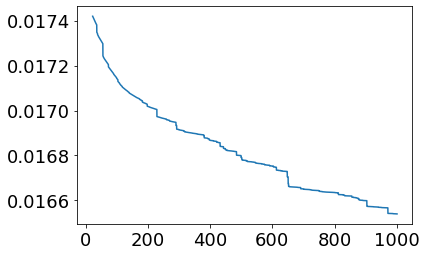

In [41]:
for i in range(len(outputs)):
    plt.plot(outputs[i][0], outputs[i][1])
    plt.show()

In [185]:
# put in grams/s
# 10^8-9 g/s is the lower limit (avg mass loss rate)
# instantaneous mass loss rate
# get LHE from DEM
# is the EUV response the same (flare/quiescent) in the FUV lines

In [42]:
Rp_aumicc = 3.24 * 6.371e8
Age_aumicc = 23. 
mcore = 5.

Teq = 454. # equil temperature
Xiron = 1./3. # Iron mass fraction in core
Xice = 0. # Ice mass fraction in core
sep = 0.1101*1.5e13 # orbital separation
G = 6.67e-8 # G in cgs

MAX_AGE = 1000. 

# low-mass loss efficiency
np.random.seed(456)

outputs_c = []

for mcore in [5,8,10]:
    print('----- MCORE = {} -----'.format(mcore))

    t1,x1,Rp1,lhe1,a1,m1 = solve_problem(Rp_aumicc, Age_aumicc, 
                                        mcore, eta, flares=False,
                                        time_cutoff=MAX_AGE)
    outputs_c.append([t1,x1,Rp1,lhe1,a1,m1])

    for cutoff in [200,MAX_AGE]:
        print('----- CUTOFF = {} -----'.format(cutoff))
        t2,x2,Rp2,lhe2,a2,m2 = solve_problem(Rp_aumicc, Age_aumicc, 
                                            mcore, eta, flares=True,
                                            time_cutoff=cutoff)
        outputs_c.append([t2,x2,Rp2,lhe2,a2,m2])

----- MCORE = 5 -----
----- CUTOFF = 200 -----
----- CUTOFF = 1000.0 -----
----- MCORE = 8 -----
----- CUTOFF = 200 -----
----- CUTOFF = 1000.0 -----
----- MCORE = 10 -----
----- CUTOFF = 200 -----
----- CUTOFF = 1000.0 -----


## Save outputs

In [43]:
fkeys = ['flares_0000', 'flares_0200', 'flares_1000']
mkeys = ['mcore_05', 'mcore_08', 'mcore_10']
dkeys = ['time', 'x', 'Rp', 'L', 'Flare_E', 'Mdot']

In [44]:
dict_c = {}
x, y = 0, 0
for i in range(len(outputs_c)):
    tempdict = {}
    for j in range(len(outputs_c[i])):
        tempdict[dkeys[j]] = outputs_c[i][j]
    key = mkeys[x] + '_' + fkeys[y]
    dict_c[key] = tempdict
    y += 1
    if y == 3:
        y = 0
        x += 1
    print(key, np.nanmedian(outputs_c[i][-1])/10**8)

mcore_05_flares_0000 0.6110196806767881
mcore_05_flares_0200 0.7119977066760018
mcore_05_flares_1000 1.7461977862399596
mcore_08_flares_0000 0.4395100396121184
mcore_08_flares_0200 0.5150904050286075
mcore_08_flares_1000 1.338966719227279
mcore_10_flares_0000 0.37563318869612855
mcore_10_flares_0200 0.43266512566534937
mcore_10_flares_1000 1.167759197776784


In [45]:
dict_b = {}
x, y = 0, 0
for i in range(len(outputs)):
    tempdict = {}
    for j in range(len(outputs[i])):
        tempdict[dkeys[j]] = outputs[i][j]
    key = mkeys[x] + '_' + fkeys[y]
    dict_b[key] = tempdict
    y += 1
    if y == 3:
        y = 0
        x += 1
    print(key, np.nanmedian(outputs[i][-1])/10**8)

mcore_05_flares_0000 2.5414303680202726
mcore_05_flares_0200 2.9435476038145514
mcore_05_flares_1000 7.437002875156516
mcore_08_flares_0000 1.8534665834892317
mcore_08_flares_0200 2.1743998875337796
mcore_08_flares_1000 5.924806302592282
mcore_10_flares_0000 1.5846834031662393
mcore_10_flares_0200 1.8266428256467435
mcore_10_flares_1000 5.159294102758853


In [46]:
np.save('/Users/belugawhale/Documents/GitHub/cos_flares/data/au_mic_b_atm.npy',
        dict_b)
np.save('/Users/belugawhale/Documents/GitHub/cos_flares/data/au_mic_c_atm.npy',
        dict_c)

## Plot outputs

In [47]:
COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 12 #12
plt.rcParams['ytick.major.size']  = 12 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

if COLOR=='k':
    path='/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/light-bkg/'
else:
    path='/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/dark-bkg/'

In [48]:
outputs = np.load('/Users/belugawhale/Documents/GitHub/cos_flares/data/au_mic_b_atm.npy',
                  allow_pickle=True)
outputs = outputs.tolist()

In [49]:
def plot_box(out, inds, ax):
    qs = []
    x=0
    median = []
    for i in inds:
        qs.append(out[i]['Mdot']>0)
        median.append(np.nanmedian(out[i]['Mdot'][qs[x]])/1e8)
        x+=1
    fig = ax.boxplot([np.log10(out[inds[0]]['Mdot'][qs[0]]), 
                     np.log10(out[inds[1]]['Mdot'][qs[1]]), 
                     np.log10(out[inds[2]]['Mdot'][qs[2]])],
                     flierprops=flierprops,
                     medianprops=medianprops, boxprops=boxprops,
                     capprops=medianprops,whiskerprops=medianprops,
                     showfliers=False, patch_artist=True)
    return fig, median

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_7909/831392423.py:51: UserWarning: Use the colorbar set_ticks() method instead.
  cbar_ax.set_yticks(yticks)
/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_7909/831392423.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(['{0} x 10$^8$'.format(i) for i in yticks])
/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_7909/831392423.py:63: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/belugawhale/Documents/AUMic/paper/mass_loss.pdf',


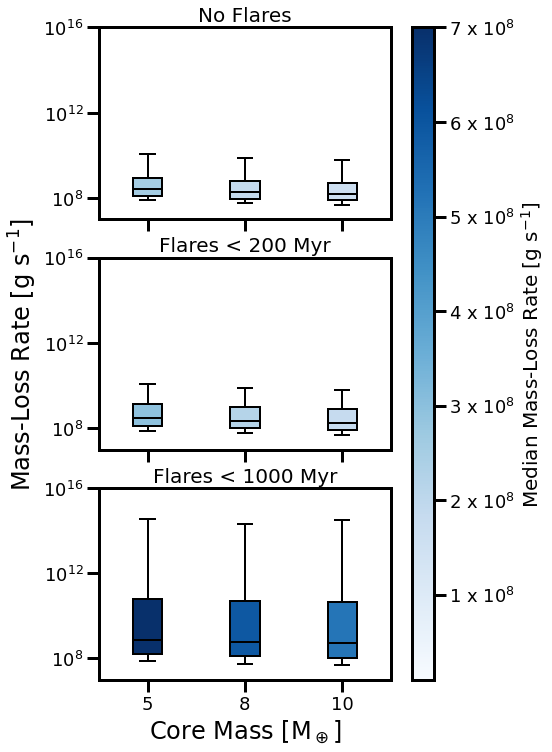

In [52]:
flierprops = {'marker':'.', 'ms':1, 'color':'k'}
medianprops = {'lw':2, 'color':'k'}
boxprops = {'lw':2, 'color':'k'}

vmin, vmax = 0.1, 7

fig, (ax1, ax3, ax5) = plt.subplots(ncols=1, nrows=3,
                                    figsize=(6,12), sharex=True,
                                    sharey=True)
fig.set_facecolor('w')

b1, m1 = plot_box(outputs, inds=['mcore_05_flares_0000', 
                                 'mcore_08_flares_0000',
                                 'mcore_10_flares_0000'], ax=ax1)
b2, m2 = plot_box(outputs, inds=['mcore_05_flares_0200', 
                                 'mcore_08_flares_0200',
                                 'mcore_10_flares_0200'], ax=ax3)
b3, m3 = plot_box(outputs, inds=['mcore_05_flares_1000', 
                                 'mcore_08_flares_1000',
                                 'mcore_10_flares_1000'], ax=ax5)


label = ['No Flares', 'Flares < 200 Myr','Flares < 1000 Myr']
for i,ax in enumerate([ax1, ax3, ax5]):
    ax.set_title(label[i], fontsize=20)

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
axes = [b1, b2, b3]
meds = [m1, m2, m3]
for i in range(len(axes)):
    bplot = axes[i]
    for j in range(len(bplot['boxes'])):
        patch = bplot['boxes'][j]
        patch.set_facecolor(matplotlib.colors.rgb2hex(cm.Blues(norm(meds[i][j]))))

ax3.set_xticks([1,2,3])
ax3.set_xticklabels(['5', '8', '10'])
ax5.set_xlabel('Core Mass [M$_\oplus$]', fontsize=24)

ax3.set_ylabel('Mass-Loss Rate [g s$^{-1}$]', fontsize=24)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.125, 0.05, 0.755])
im = ax1.scatter(np.arange(-10,-9,1), np.arange(-10,-9,1),
                 c=np.arange(-10,-9,1), 
                 vmin=vmin, vmax=vmax, cmap='Blues')
fig.colorbar(im, cax=cbar_ax)


yticks = np.arange(1, vmax+1,1,dtype=int)
cbar_ax.set_yticks(yticks)
cbar_ax.set_yticklabels(['{0} x 10$^8$'.format(i) for i in yticks])
cbar_ax.set_ylabel('Median Mass-Loss Rate [g s$^{-1}$]')

yticks = np.arange(8,20,4)
ax1.set_yticks(yticks)
ax1.set_yticklabels(['10$^8$', '10$^{12}$', '10$^{16}$'])

ax1.set_ylim(7,16)

ax1.set_xlim(0.5,3.5)

plt.savefig('/Users/belugawhale/Documents/AUMic/paper/mass_loss.pdf',
            dpi=300, rasterize=True, bbox_inches='tight')

In [51]:
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
colors = [matplotlib.colors.to_rgb('#F7B666'),
          matplotlib.colors.to_rgb('#F39724'),
          matplotlib.colors.to_rgb('#B90D49'),
          matplotlib.colors.to_rgb('#650828')] 

cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_96118/3138285508.py:52: UserWarning: Use the colorbar set_ticks() method instead.
  cbar_ax.set_yticks(yticks)
/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_96118/3138285508.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(['{0} x 10$^8$'.format(i) for i in yticks])
/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_96118/3138285508.py:63: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(path, 'mass_loss.png'), transparent=True,


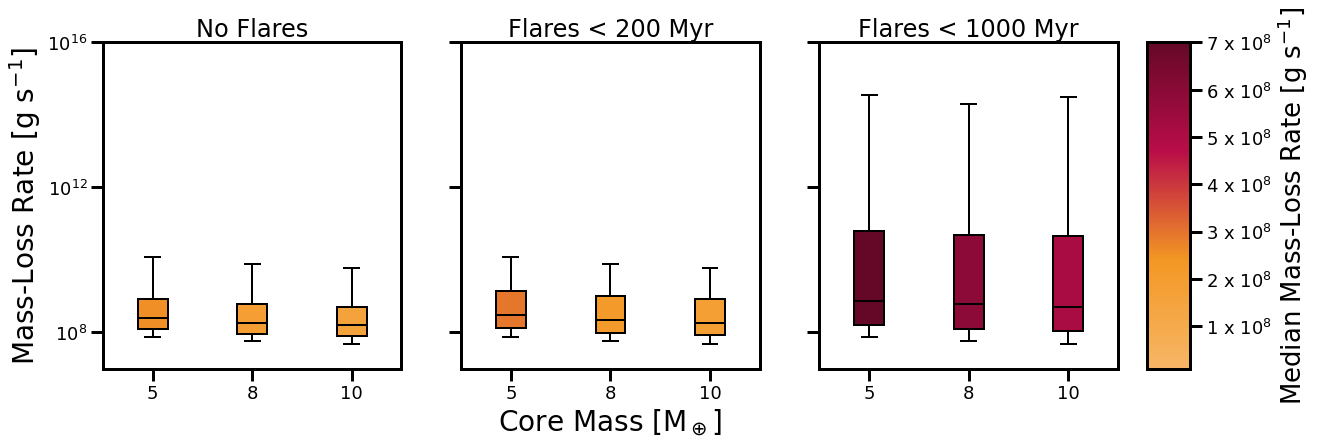

In [58]:
plt.rcParams['font.size'] = 26

flierprops = {'marker':'.', 'ms':1, 'color':COLOR}
medianprops = {'lw':2, 'color':COLOR}
boxprops = {'lw':2, 'color':COLOR}

vmin, vmax = 0.1, 7

fig, (ax1, ax3, ax5) = plt.subplots(ncols=3, nrows=1,
                                    figsize=(20,6), sharex=True,
                                    sharey=True)

b1, m1 = plot_box(outputs, inds=['mcore_05_flares_0000', 
                                 'mcore_08_flares_0000',
                                 'mcore_10_flares_0000'], ax=ax1)
b2, m2 = plot_box(outputs, inds=['mcore_05_flares_0200', 
                                 'mcore_08_flares_0200',
                                 'mcore_10_flares_0200'], ax=ax3)
b3, m3 = plot_box(outputs, inds=['mcore_05_flares_1000', 
                                 'mcore_08_flares_1000',
                                 'mcore_10_flares_1000'], ax=ax5)


label = ['No Flares', 'Flares < 200 Myr','Flares < 1000 Myr']
for i,ax in enumerate([ax1, ax3, ax5]):
    ax.set_title(label[i], fontsize=24)

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
axes = [b1, b2, b3]
meds = [m1, m2, m3]
for i in range(len(axes)):
    bplot = axes[i]
    for j in range(len(bplot['boxes'])):
        patch = bplot['boxes'][j]
        patch.set_facecolor(matplotlib.colors.rgb2hex(cmap(norm(meds[i][j]))))

ax3.set_xticks([1,2,3])
ax3.set_xticklabels(['5', '8', '10'])
ax3.set_xlabel('Core Mass [M$_\oplus$]', fontsize=28)

ax1.set_ylabel('Mass-Loss Rate [g s$^{-1}$]', fontsize=28)

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.125, 0.03, 0.755])
im = ax1.scatter(np.arange(-10,-9,1), np.arange(-10,-9,1),
                 c=np.arange(-10,-9,1), 
                 vmin=vmin, vmax=vmax, cmap=cmap)
fig.colorbar(im, cax=cbar_ax)


yticks = np.arange(1, vmax+1,1,dtype=int)
cbar_ax.set_yticks(yticks)
cbar_ax.set_yticklabels(['{0} x 10$^8$'.format(i) for i in yticks])
cbar_ax.set_ylabel('Median Mass-Loss Rate [g s$^{-1}$]')

yticks = np.arange(8,20,4)
ax1.set_yticks(yticks)
ax1.set_yticklabels(['10$^8$', '10$^{12}$', '10$^{16}$'])

ax1.set_ylim(7,16)
ax1.set_xlim(0.5,3.5)

plt.savefig(os.path.join(path, 'mass_loss.png'), transparent=True,
            dpi=300, rasterize=True, bbox_inches='tight')